Wine - Quality - Classification

- Ke Deng
- Dataset: Wine Dataset

# 1 - Data Processing Phase
Import Python packages we will use in this project.
## 1.1 - Download and Read

In [7]:
import wget
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from IPython.display import Markdown, display
from statistics import *

from sklearn import metrics
from sklearn import svm
from sklearn import tree
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve, roc_curve, auc, precision_recall_fscore_support, accuracy_score 

from sklearn.model_selection import train_test_split
from numpy import interp


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

Download data from the website.

In [8]:
## download red-wine data if they are not in current directory
if not os.path.isfile('winequality-red.csv'):
    wget.download(url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv')

## download white-wine data if they are not in current directory
if not os.path.isfile('winequality-red.csv'):
    wget.download(url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv')

#read data from files
data_red = pd.read_csv('winequality-red.csv',sep = ';')
data = pd.read_csv('winequality-white.csv', sep = ';')
data.reset_index(inplace = True, drop = True)

data['class'] = [1 if i > 5 else 0 for i in data['quality']]
data['class'] = data['class'].astype('float64')
data.drop(columns = ['quality'], inplace = True)

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  class                 4898 non-null   float64
dtypes: float64(12)
memory usage: 459.3 KB
None


Thre is no missing value in this dataset.
## 1.2 - Normalization 
We use min-max normalization to normalize whole dataset.

In [9]:
X = data.drop(['class'], axis=1).copy()
y = data['class']
# X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.25, random_state=1)
# Normalization
# Fitting only on training data


# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df = pandas.DataFrame(x_scaled)

min_max_scaler = preprocessing.MinMaxScaler()
X = pd.DataFrame(min_max_scaler.fit_transform(X))

# 2 - Models
We firstly define a function which returns accuracy, true positive rate, false positive rate, precision, and F-score in binary classification. In this case, we use 10-fold cross validation, so there is no need to split our dataset.

In [10]:
def my_confusion_matrix(test, pred):
    tp = tn = fp = fn = 0
    for i in range(len(test)):
        if pred[i] == 1 and test[i] == 1:
            tp = tp + 1
        elif pred[i] == 0 and test[i] == 0:
            tn = tn + 1
        elif pred[i] == 1 and test[i] == 0:
            fp = fp + 1
        else:
            fn = fn + 1
    accuracy = (tp + tn)/(tp + tn + fp + fn)
    true_pos_rate = tp/(tp + fn)
    false_pos_rate = fp/(fp + tn)
    precision = tp/(tp + fp)
    f_score = 2*true_pos_rate*precision/(true_pos_rate + precision)
    return accuracy, true_pos_rate, false_pos_rate, precision, f_score 

## 2.1 - Logistic Regression
The first model we choose is logistic regression. 
- Use default L2 penalties, which outperforms L1 with higher accuracy 
- We can not see very obvious improvement on accuracy by increasing times of iteration, therefore, we set iteration times as its default value 100. After training this model using training dataset 

We use We use 10-fold corss validation to exam the model and gain an average accuracy. Following table shows the accuracy, TPR, FPR, precision, F-score on validation dataset. The figure shows ROC curve given by each iteration, the grey area stands for average ROC curve.

Average accuracy of logistic regression model is 0.7403


,Accuracy,True Positive Rate,False Positive Rate,Precision,F-Score
0,0.655102,0.749186,0.502732,0.714286,0.731320
1,0.740816,0.828660,0.426036,0.786982,0.807284
2,0.736735,0.841463,0.475309,0.781870,0.810573
3,0.748980,0.840764,0.414773,0.783383,0.811060
4,0.667347,0.837838,0.523810,0.642012,0.726968
5,0.765306,0.939683,0.548571,0.755102,0.837341
6,0.793878,0.949735,0.732143,0.814059,0.876679
7,0.806122,0.960000,0.578571,0.805755,0.876141
8,0.723926,0.854938,0.533333,0.758904,0.804064
9,0.764826,0.895028,0.606299,0.807980,0.849279


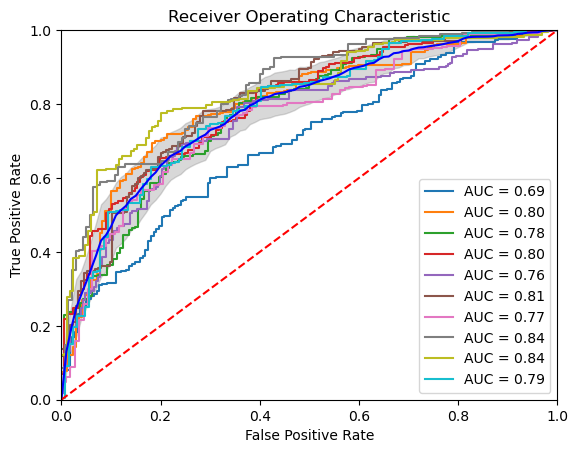

In [11]:
log_reg = LogisticRegression()
kf = KFold(n_splits=10)
kf.get_n_splits(X)
KFold(n_splits=10, random_state=None, shuffle=False)
log_reg_cfsn_matrix = pd.DataFrame(columns = ('Accuracy', 'True Positive Rate', 'False Positive Rate', 'Precision', 'F-Score'))

tprs = []
base_fpr = np.linspace(0, 1, 101)

for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    log_reg.fit(X_train, y_train)
    log_reg_pred = log_reg.predict(X_test)
    log_reg_prob = log_reg.predict_proba(X_test)
    
    y_test_temp = y_test.tolist()
    log_reg_cfsn_matrix.loc[len(log_reg_cfsn_matrix)] = my_confusion_matrix(y_test_temp, log_reg_pred)
    
    fpr, tpr, thresholds = roc_curve(y_test, log_reg_prob[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std
plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


print("Average accuracy of logistic regression model is %0.4f" % mean(log_reg_cfsn_matrix['Accuracy']))
log_reg_cfsn_matrix

## 2.2 - Support Vector Machine
The second model we choose is support vector machine.
- Set kernel as rbf, wich outperformes 'linear, 'poly' and 'sigmoid' kernels
- Set C as 1, which gives the highest accuracy amongst 0.1, 0.5, 1 and 10
- Set tolerance for stopping criteria as 1e-3, which gives the highest accuracy amongst 1e-1, 1e-2, 1e-3, 1e-4 and 1e-5

We use 10-fold corss validation to exam the model and gain an average accuracy. The figure shows ROC curve given by each iteration, the grey area stands for average ROC curve.

Average accuracy of support vector machine is 0.7473


,Accuracy,True Positive Rate,False Positive Rate,Precision,F-Score
0,0.718750,0.361702,0.132743,0.531250,0.430380
1,0.725000,0.589744,0.146341,0.793103,0.676471
2,0.768750,0.780952,0.254545,0.854167,0.815920
3,0.693750,0.681319,0.289855,0.756098,0.716763
4,0.743750,0.500000,0.132075,0.658537,0.568421
5,0.781250,0.886598,0.380952,0.781818,0.830918
6,0.800000,0.863248,0.372093,0.863248,0.863248
7,0.775000,0.820755,0.314815,0.836538,0.828571
8,0.756250,0.733333,0.223529,0.743243,0.738255
9,0.710692,0.776471,0.364865,0.709677,0.741573


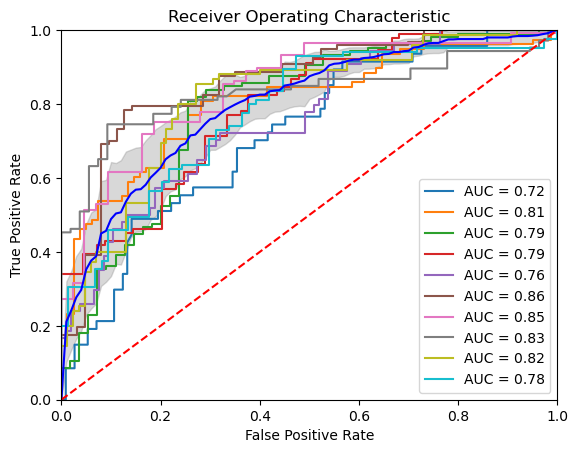

In [26]:
svc = svm.SVC(kernel = 'rbf', C = 1, tol = 1e-3, probability=True)
# kf = KFold(n_splits=10)
# kf.get_n_splits(X)
# KFold(n_splits=10, random_state=None, shuffle=False)
svc_cfsn_matrix = pd.DataFrame(columns = ('Accuracy', 'True Positive Rate', 'False Positive Rate', 'Precision', 'F-Score'))
tprs = []
base_fpr = np.linspace(0, 1, 101)

for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    svc.fit(X_train, y_train)
    svc_pred = svc.predict(X_test)
    svc_prob = svc.predict_proba(X_test)
    
    y_test_temp = y_test.tolist()
    svc_cfsn_matrix.loc[len(svc_cfsn_matrix)] = my_confusion_matrix(y_test_temp, svc_pred)
    
    fpr, tpr, thresholds = roc_curve(y_test, svc_prob[:,1]) 
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
    
    # to plot average area
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std
plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


print("Average accuracy of support vector machine is %0.4f" % mean(svc_cfsn_matrix['Accuracy']))
svc_cfsn_matrix

# 2.3 - Decision Tree
The third model we choose is decision tree. We set gini index as criterion. 
- Set Gini Index as spliting criteria, which outperformes Entropy with a higher accuracy
- Set min samples required to split as 5%, which gives the highest accuracy amongst 1%, 5%, and 10%
- Set min samples required at leaf as 0.1 % which gives the highest accuracy amongst 0.1%, 1%, 5%

We use 10-fold corss validation to exam the model and gain an average accuracy. The figure shows ROC curve given by each iteration, the grey area stands for average ROC curve.

Average accuracy of decision tree model is 0.6935


,Accuracy,True Positive Rate,False Positive Rate,Precision,F-Score
0,0.681250,0.574468,0.274336,0.465517,0.514286
1,0.681250,0.538462,0.182927,0.736842,0.622222
2,0.656250,0.714286,0.454545,0.750000,0.731707
3,0.706250,0.670330,0.246377,0.782051,0.721893
4,0.662500,0.518519,0.264151,0.500000,0.509091
5,0.718750,0.835052,0.460317,0.736364,0.782609
6,0.775000,0.854701,0.441860,0.840336,0.847458
7,0.706250,0.773585,0.425926,0.780952,0.777251
8,0.718750,0.706667,0.270588,0.697368,0.701987
9,0.628931,0.729412,0.486486,0.632653,0.677596


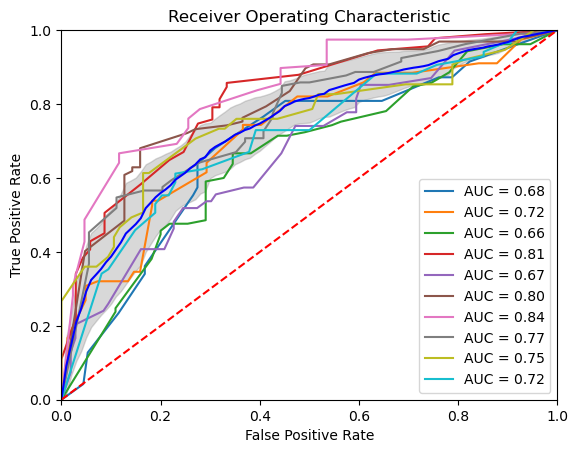

In [27]:
clf = tree.DecisionTreeClassifier(criterion = 'gini', min_samples_split = 0.05, min_samples_leaf = 0.001)
# kf = KFold(n_splits=10)
# kf.get_n_splits(X)
# KFold(n_splits=10, random_state=None, shuffle=False)
clf_cfsn_matrix = pd.DataFrame(columns = ('Accuracy', 'True Positive Rate', 'False Positive Rate', 'Precision', 'F-Score'))
tprs = []
base_fpr = np.linspace(0, 1, 101)

for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train)
    clf_pred = clf.predict(X_test)
    clf_prob = clf.predict_proba(X_test)
    
    y_test_temp = y_test.tolist()
    clf_cfsn_matrix.loc[len(clf_cfsn_matrix)] = my_confusion_matrix(y_test_temp, clf_pred)
    
    fpr, tpr, thresholds = roc_curve(y_test, clf_prob[:,1]) 
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
    # to plot average area
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std
plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


print("Average accuracy of decision tree model is %0.4f" % mean(clf_cfsn_matrix['Accuracy']))
clf_cfsn_matrix

# 2.4 - Random Forest
The fourth model we choose is random forest. 

- Set number of estimators as 100, which is the best amongst 10, 50 and 100
- Set splitting criteria as Gini Index 
- Set min samples required to split: 5% 
- Set min samples required at leaf as 0.1% 

We use 10-fold corss validation to exam the model and gain an average accuracy. The figure shows ROC curve given by each iteration, the grey area stands for average ROC curve.

Average accuracy of random forest model is 0.7411


,Accuracy,True Positive Rate,False Positive Rate,Precision,F-Score
0,0.718750,0.489362,0.185841,0.522727,0.505495
1,0.706250,0.576923,0.170732,0.762712,0.656934
2,0.750000,0.819048,0.381818,0.803738,0.811321
3,0.743750,0.769231,0.289855,0.777778,0.773481
4,0.712500,0.481481,0.169811,0.590909,0.530612
5,0.737500,0.907216,0.523810,0.727273,0.807339
6,0.775000,0.837607,0.395349,0.852174,0.844828
7,0.768750,0.811321,0.314815,0.834951,0.822967
8,0.756250,0.746667,0.235294,0.736842,0.741722
9,0.742138,0.823529,0.351351,0.729167,0.773481


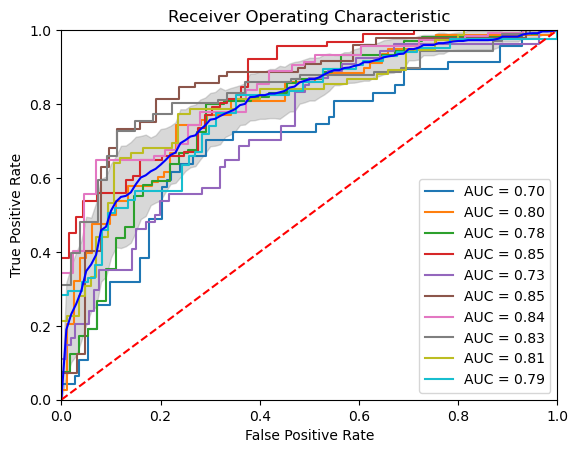

In [28]:
r_forest = RandomForestClassifier(n_estimators=100, criterion = 'gini', 
                                  max_features = None,  min_samples_split = 0.05, min_samples_leaf = 0.001)
# kf = KFold(n_splits=10)
# kf.get_n_splits(X)
# KFold(n_splits=10, random_state=None, shuffle=False)
forest_cfsn_matrix = pd.DataFrame(columns = ('Accuracy', 'True Positive Rate', 'False Positive Rate', 'Precision', 'F-Score'))
tprs = []
base_fpr = np.linspace(0, 1, 101)

for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    r_forest.fit(X_train, y_train)
    r_forest_pred = r_forest.predict(X_test)
    r_forest_prob = r_forest.predict_proba(X_test)
    
    y_test_temp = y_test.tolist()
    forest_cfsn_matrix.loc[len(forest_cfsn_matrix)] = my_confusion_matrix(y_test_temp, r_forest_pred)
    
    fpr, tpr, thresholds = roc_curve(y_test, r_forest_prob[:,1]) 
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
    # to plot average area
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std
plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


print("Average accuracy of random forest model is %0.4f" % mean(forest_cfsn_matrix['Accuracy']))
forest_cfsn_matrix

# 3 - Model Evaluation
## 3.1 - Overall Performance Statistics
We aggregate average performence statistics into one talbe and plot average ROC curve in one figure to compare models.

In [29]:
overall_eval = pd.concat([log_reg_cfsn_matrix.mean(axis=0), 
                          svc_cfsn_matrix.mean(axis=0), clf_cfsn_matrix.mean(axis=0), 
                          forest_cfsn_matrix.mean(axis=0)], axis = 1)
overall_eval.reset_index(inplace = True, drop = True)
overall_eval.columns = ['Logistic Regression', 'SVM','Decision Tree', 'Random Forest']
overall_eval.index = ['Accuracy', 'True Positive Rate', 'False Positive Rate', 'Precision', 'F-Score']
overall_eval

,Logistic Regression,SVM,Decision Tree,Random Forest
Accuracy,0.736069,0.747319,0.693518,0.741089
True Positive Rate,0.704660,0.699412,0.691548,0.726238
False Positive Rate,0.279973,0.261182,0.350751,0.301868
Precision,0.733057,0.752768,0.692208,0.733827
F-Score,0.713327,0.721052,0.688610,0.726818


## 3.2 - Conclusion
- Randon forest model gives the highest F-score and accuracy.
- The average ROC curve given by random forest model is close to top left corner

So we choose random forest model as our final model. The advantage of choosing random forest is that it is very easy to measure the relative importance of each feature on the prediction

# 4 - Prediction
Use logistic regression model to make prediction on our test dataset. We newly split our data into training and test dataset. And train a random forest model then deploy it to make prediction. 

,Accuracy,True Positive Rate,False Positive Rate,Precision,F-Score
0,0.779167,0.768,0.208696,0.8,0.783673


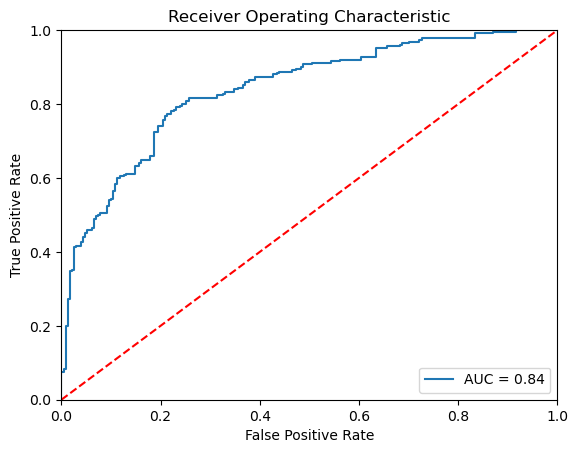

In [30]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=1)
r_forest = RandomForestClassifier(n_estimators=100, criterion = 'gini', 
                                  max_features = None,  min_samples_split = 0.05, min_samples_leaf = 0.001)
test_matrix = pd.DataFrame(columns = ('Accuracy', 'True Positive Rate', 'False Positive Rate', 'Precision', 'F-Score'))
r_forest.fit(X_train, y_train)
r_forest_pred = r_forest.predict(X_test)
r_forest_prob = r_forest.predict_proba(X_test)
    
y_test_temp = y_test.tolist()
test_matrix.loc[len(test_matrix)] = my_confusion_matrix(y_test_temp, r_forest_pred)
    
fpr, tpr, thresholds = roc_curve(y_test, r_forest_prob[:,1]) 
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
test_matrix
